### Задачи:
- Выбрать и описать набор данных
- Провести очистку данных и преобразовать атрибуты в числовые признаки
- Разделить набор данных на обучающую и тестовую выборки
- Обучить несколько моделей
- Выбрав лучшую модель, провести её усовершенствование
- Представить окончательные результаты, предложив альтернативные варианты решения

In [14]:
import time
import numpy as np
import pandas as pd

# работа с текстом
import spacy
from collections import Counter
import string
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, StratifiedKFold

# модели
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

# метрики
import optuna
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Выбор и описание набора данных (п.1)

### *Датасет "Twitter Sentiment" представляет собой собрание постов из Twitter, классифицированных по характеру выраженного в них мнения или проявленной эмоции. Этот набор данных включает твиты, которые разделены на четыре категории: "Positive", "Negative", "Neutral" и "Irrelevant".*
### *Категории "Positive" и "Negative" содержат твиты с явно выраженной положительной/отрицательной эмоцией, в то время как "Neutral" — твиты с нейтральным содержанием. "Irrelevant" же представляет из себя сообщения, которые не относятся к теме исследования или не содержат выражения мнения/эмоций как таковых.*

In [4]:
cols = ['id', 'object', 'sentiment', 'text']
df = pd.read_csv('twitter_training.csv', names=cols)
df.head()

,id,object,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


# Анализ и очистка данных (п. 2, 4)

### *Выявление и удаление пропущенных значений*

In [4]:
df.isna().sum()

id             0
object         0
sentiment      0
text         686
dtype: int64

### *Все обнаруженные пропуски находятся в столбце text. Так как их восстановление не является возможным, просто избавляемся от них*

In [5]:
df.dropna(inplace=True)
df.isna().sum()

id           0
object       0
sentiment    0
text         0
dtype: int64

### *Следующим шагом будет обнаружение и удаление стоп-слов — слов, которые как таковой смысловой нагрузки не несут, однако при этом являются одними из самых распространённых*

### *Для начала выявим их наличие в нашем тексте (рассмотрев 15 наиболее встречающихся слов), зачем выведем абсолютно все стоп-слова, которые в дальнейшем будут удаляться*

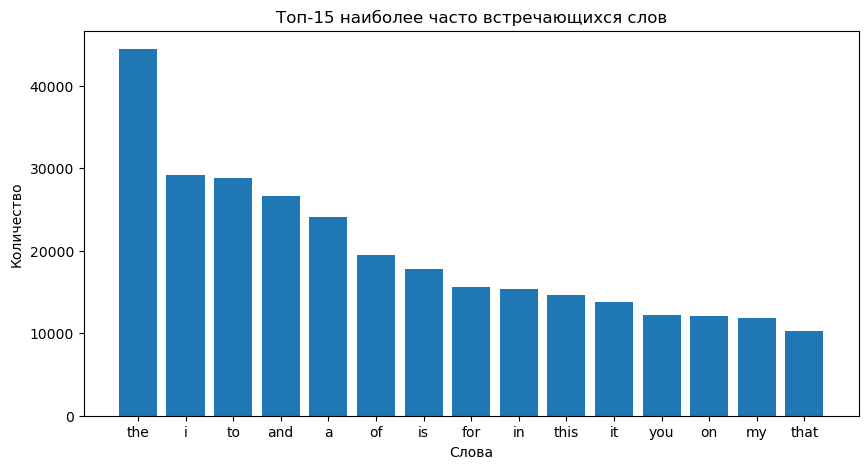

In [5]:
words = df['text'].str.lower().str.split()

words = words.apply(lambda x: [word.strip(string.punctuation) for word in x if word.strip(string.punctuation)])

all_words = [word for sublist in words for word in sublist if word]

word_counts = Counter(all_words)

most_common_words = word_counts.most_common(15)
words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xlabel('Слова')
plt.ylabel('Количество')
plt.title('Топ-15 наиболее часто встречающихся слов')
plt.xticks(rotation=0)
plt.show()

### *Все слова, подлежащие удалению*

In [6]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### *Также замечаем, что в тексте достаточно часто встречаются символы с числами, которые тоже подлежат удалению*

In [184]:
def most_common_words(text_series):
    all_text = ' '.join(text_series)
    words = all_text.split()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(20)
    return most_common_words

for i in label_mapping:
    print('-'*30)
    print(f'{i}:')
    print(most_common_words(df['preprocessed text'][df['sentiment']==label_mapping[i]]))
    print('-'*30, '\n\n')

------------------------------
Irrelevant:
[('good', 1120), ('player', 1094), ('like', 1079), ('game', 1022), ('ban', 926), ('play', 820), ('love', 726), ('people', 718), ('4', 660), ('get', 651), ('2', 635), ('thank', 574), ('>', 543), ('great', 508), ('look', 497), ('go', 483), ('<', 482), ('time', 481), ('shit', 467), ('Battlefield', 455)]
------------------------------ 


------------------------------
Negative:
[('game', 4355), ('play', 2033), ('like', 1670), ('get', 1505), ('shit', 1476), ('fix', 1326), ('go', 1271), ('fuck', 1262), ('K', 1229), ('bad', 1201), ('time', 1096), ('2', 1018), ('fucking', 959), ('year', 872), ('people', 847), ('try', 810), ('work', 797), ('>', 787), ('good', 757), ('new', 749)]
------------------------------ 


------------------------------
Neutral:
[('Johnson', 1780), ('play', 1445), ('2', 1415), ('game', 1374), ('good', 1040), ('Amazon', 992), ('like', 979), ('>', 834), ('3', 789), ('win', 772), ('get', 752), ('Facebook', 707), ('5', 684), ('<', 67

In [6]:
nlp = spacy.load("en_core_web_sm") 

def preprocessing(text):
    doc = nlp(text)
    filltered_words = []
    for token in doc:
        if token.is_stop or token.is_punct or not token.is_alpha or token.is_digit:
            continue
        filltered_words.append(token.lemma_)
    
    return " ".join(filltered_words)

df['preprocessed text'] = df['text'].apply(preprocessing)

In [191]:
for i in label_mapping:

    print('-'*30)
    print(f'{i}:')

    print(most_common_words(df['preprocessed text'][df['sentiment']==label_mapping[i]]))
    print('-'*30, '\n\n')

------------------------------
Irrelevant:
[('good', 1120), ('player', 1094), ('like', 1079), ('game', 1022), ('ban', 926), ('play', 820), ('love', 726), ('people', 718), ('get', 651), ('thank', 574), ('great', 508), ('look', 497), ('go', 483), ('time', 481), ('shit', 467), ('Battlefield', 455), ('unk', 451), ('know', 436), ('come', 404), ('occur', 387)]
------------------------------ 


------------------------------
Negative:
[('game', 4355), ('play', 2033), ('like', 1670), ('get', 1505), ('shit', 1476), ('fix', 1326), ('go', 1271), ('fuck', 1262), ('K', 1229), ('bad', 1201), ('time', 1096), ('fucking', 959), ('year', 872), ('people', 847), ('try', 810), ('work', 797), ('good', 757), ('new', 749), ('server', 747), ('know', 732)]
------------------------------ 


------------------------------
Neutral:
[('Johnson', 1780), ('play', 1445), ('game', 1374), ('good', 1040), ('Amazon', 992), ('like', 979), ('win', 772), ('get', 752), ('Facebook', 707), ('time', 676), ('new', 675), ('thank',

### *Убедимся в окончательной очистке текста*

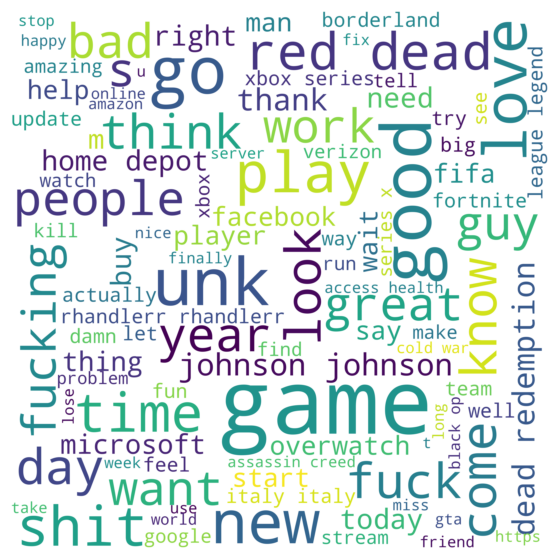

In [192]:
word_cloud_text = ' '.join(df["preprocessed text"].astype(str)).lower()

wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=600,
    height=600
).generate(word_cloud_text)
    
plt.figure(figsize=(7,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### *Рассмотрим распределение целевой переменной*

<AxesSubplot:xlabel='sentiment', ylabel='count'>

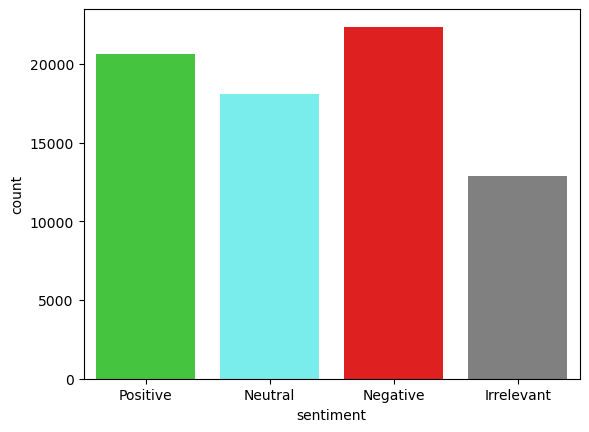

In [80]:
colors = ['#30DA2A', '#66FFFF', 'red', 'gray']
sns.countplot(data=df, x='sentiment', palette=colors)

### *Выведем наиболее часто встречающиеся слова для каждой из категорий*

In [199]:
def wc(sentiment, colormap='Blues', background='white', size=500):
    word_cloud_text = ' '.join(df["preprocessed text"][df['sentiment']==label_mapping[sentiment]].astype(str)).lower()
    wordcloud = WordCloud(
        max_font_size = 100,
        max_words = 100,
        background_color = background,
        colormap = colormap,
        scale = 10,
        width = size,
        height = size
    ).generate(word_cloud_text)
    
    return wordcloud

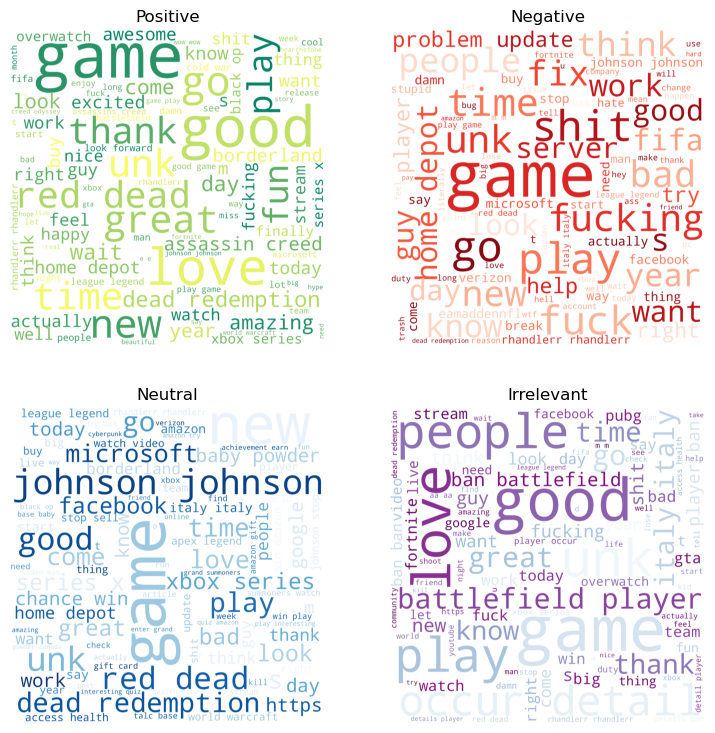

In [200]:
wc_positive = wc('Positive', 'summer')
wc_negative = wc('Negative', 'Reds')
wc_neutral = wc('Neutral', 'Blues')
wc_irrelevant = wc('Irrelevant', 'BuPu')

fig, axes = plt.subplots(2,2, figsize=(9, 9))

axes[0,0].imshow(wc_positive, interpolation="bilinear")
axes[0,0].axis("off")
axes[0,0].set_title('Positive')

axes[0,1].imshow(wc_negative, interpolation="bilinear")
axes[0,1].axis("off")
axes[0,1].set_title('Negative')

axes[1,0].imshow(wc_neutral, interpolation="bilinear")
axes[1,0].axis("off")
axes[1,0].set_title('Neutral')

axes[1,1].imshow(wc_irrelevant, interpolation="bilinear")
axes[1,1].axis("off")
axes[1,1].set_title('Irrelevant')

plt.show()

# Преобразование в числовые признаки (п.3)

In [7]:
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95)
X = vectorizer.fit_transform(df['preprocessed text'])

le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])
y = df['sentiment']

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Разделение набора на обучающую и тестовые выборки (п.6)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,, stratify=y)

# Обучаем и сравниваем следующие модели (п.7):
### - Logistic Regression
### - Naive Bayes
### - Perceptron
### - Decision Tree
### - SVC
### - KNN
### - Random Forest

In [15]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def show_results(models, model_names, cv_folds=5):
    results = {'accuracy':[], 'f1-score':[], 'time':[]}
    scoring = ['accuracy', 'f1_macro']
    cv = cv_folds
    
    for model in models:
        start_time = time.time()
    
        scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)
        
        end_time = time.time()
        training_time = (end_time - start_time) / 60 / cv_folds
        
        results['accuracy'].append(scores['test_accuracy'].mean())
        results['f1-score'].append(scores['test_f1_macro'].mean())
        results['time'].append(training_time)
        
    return pd.DataFrame(results, index=model_names).T

In [16]:
models = [
    LogisticRegression(max_iter=1000),
    MultinomialNB(),
    Perceptron(),
    DecisionTreeClassifier(),
    SVC(),
    KNeighborsClassifier(),
    RandomForestClassifier(n_jobs=-1)
]

model_names = [
    'Logistic Regression',
    'Naive Bayes',
    'Perceptron',
    'Decision Tree',
    'SVC',
    'KNN',
    'Random Forest'
]

D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

In [18]:
comparison = show_results(models, model_names)
comparison

,Logistic Regression,Naive Bayes,Perceptron,Decision Tree,SVC,KNN,Random Forest
accuracy,0.764,0.707,0.815,0.788,0.900,0.829,0.899
f1-score,0.758,0.683,0.813,0.783,0.900,0.828,0.898
time,0.241,0.001,0.008,0.384,23.250,0.291,0.834


# (п.8, 9)
### *Несмотря на то что лучшие метрики демонстрирует модель SVC, выбираем Random Forest, так как обучается он в целых 28 раз быстрее, в то время как значение метрик ниже лишь на 0.002*

### *Используем эту модель для дальнейшего подбора оптимальных гиперпараметров*

In [98]:
rf = RandomForestClassifier(n_jobs=-1)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Рассматриваем следующие гиперпараметры:
- n_estimators
- max_depth
- max_leaf_nodes
- class_weight
- criterion
- max_features

In [124]:
estimators = {'n_estimators': [3, 5, 10, 25, 50, 100, 200]}
max_depth = {'max_depth': [5, 10, 20, 40, 75, 150, 300, 500, 800]}
max_leaf_nodes = {'max_leaf_nodes': [5, 10, 20, 50, 100, 200, 400, None]}

scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro'
}

In [107]:
def plot_train_test_curves(train_scores, test_scores, parameters, parameter):

    plt.plot(parameters, train_scores, label='train scores', color='red')
    plt.plot(parameters, test_scores, label='test scores', color='green')

    plt.xlabel(parameter)
    plt.ylabel('accuracy')
    plt.legend()

    

def gridplot(model, params):
    gs = GridSearchCV(estimator=model, 
                  param_grid=params, 
                  cv=5, 
                  scoring=scoring, 
                  refit='accuracy', 
                  return_train_score=True)
    gs.fit(X_train, y_train)
    
    results = gs.cv_results_
    
    params_list = list(params.values())[0]
    if None in params_list:
        params_list[params_list.index(None)] = 'None'

    plot_train_test_curves(
    results['mean_train_accuracy'], 
    results['mean_test_accuracy'],
    params_list,
    list(params.keys())[0])

### *Отмечаем, что повышение точности модели перестаёт увеличиваться в достаточной степени, начиная с n_estimators = 50, в то время как временные затраты продолжают расти. Остановимся на 50*

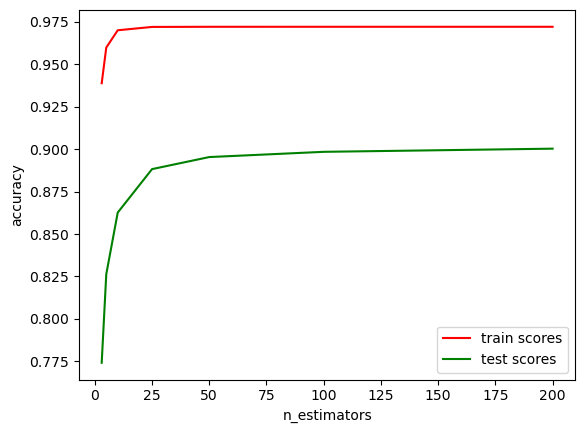

In [132]:
plot_train_test_curves(
    results['mean_train_f1_macro'], 
    results['mean_test_f1_macro'],
    [3, 5, 10, 25, 50, 100, 200],
    'n_estimators'
)

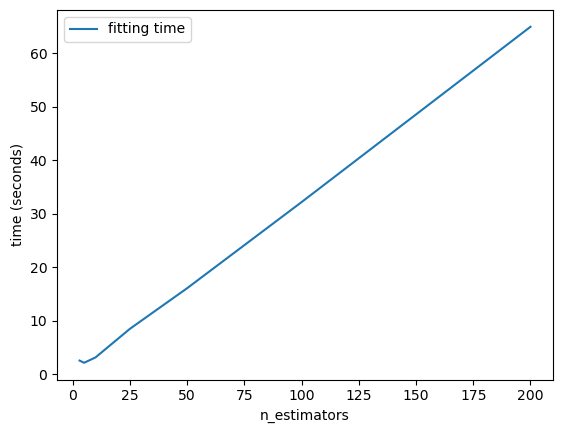

In [121]:
plt.plot(estimators['n_estimators'], results['mean_fit_time'], label='fitting time')
plt.xlabel('n_estimators')
plt.ylabel('time (seconds)')
plt.legend()

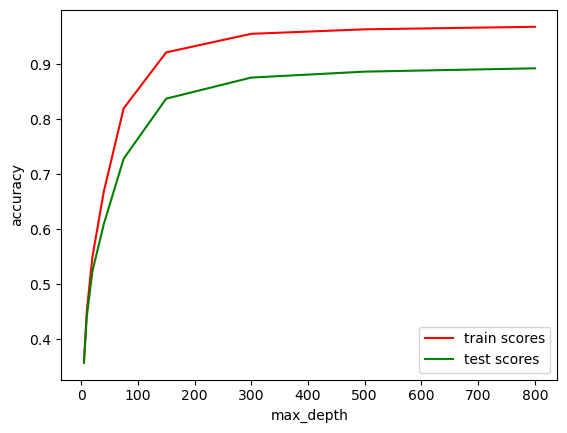

In [112]:
gridplot(RandomForestClassifier(n_jobs=-1, n_estimators=50), max_depth)

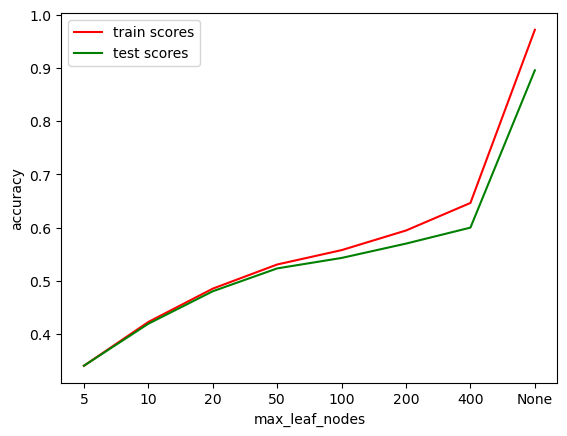

In [118]:
gridplot(RandomForestClassifier(n_jobs=-1, n_estimators=50), max_leaf_nodes)

### n_estimators = 50

In [18]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=50)

param_grid = {
    'class_weight': [None, 'balanced'],
    'criterion': ['entropy', 'gini'],
    'max_features': ['auto', 'sqrt', 'log2']
}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=scoring, refit='accuracy', cv=5, verbose=1)
gs.fit(X_train, y_train)

NameError: name 'param_grid' is not defined

In [131]:
best_params = gs.best_params_
print("Лучшие параметры: ", best_params)

Лучшие параметры:  {'class_weight': None, 'criterion': 'entropy', 'max_features': 'log2'}


# Усовершенствование модели (п.9)

In [20]:
best_params = {'class_weight': None, 'criterion': 'entropy', 'max_features': 'log2', 'n_jobs':-1, 'n_estimators':50}
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=50, n_jobs=-1)

In [21]:
y_pred_test = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1_macro = f1_score(y_test, y_pred_test, average='macro')

y_pred_train = best_rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1_macro = f1_score(y_train, y_pred_train, average='macro')

In [22]:
print(f"test accuracy: {test_accuracy}")
print(f"train accuracy: {train_accuracy}\n\n")
print(f"test f1-score: {test_f1_macro}")
print(f"train f1-score: {train_f1_macro}")

test accuracy: 0.9130405405405405
train accuracy: 0.96496384890871


test f1-score: 0.9120210395154713
train f1-score: 0.9648417270306878


In [47]:
def dimension(X, y, size=None):
    train_acc, test_acc, timer = [], [], []
    vectorizer = TfidfVectorizer(max_features=size, max_df=0.95, min_df=2)
    X = vectorizer.fit_transform(df['preprocessed text'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

    best_rf = RandomForestClassifier(**best_params)
    start = time.time()
    best_rf.fit(X_train, y_train)
    timer.append((time.time()-start)/60)
    
    y_pred_test = best_rf.predict(X_test)
    test_acc.append(accuracy_score(y_test, y_pred_test))
    
    y_pred_train = best_rf.predict(X_train)
    train_acc.append(accuracy_score(y_train, y_pred_train))
    
    return train_acc, test_acc, timer

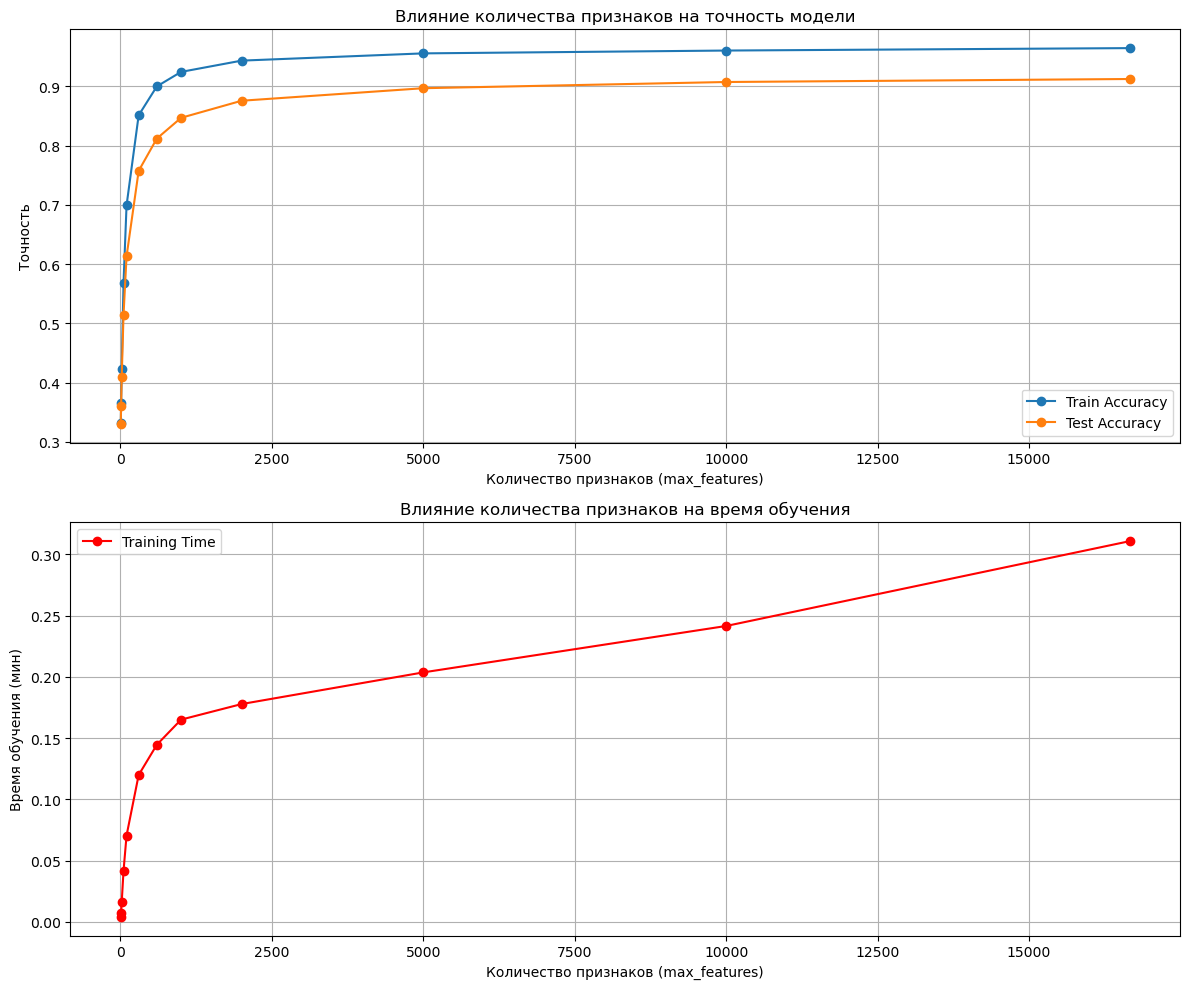

In [49]:
sizes = [5, 10, 20, 50, 100, 300, 600, 1000, 2000, 5000, 10000, 16660]

train_accuracies = []
test_accuracies = []
train_times = []

for size in sizes:
    train_acc, test_acc, times = dimension(df['preprocessed text'], y, size)
    train_accuracies.append(train_acc[0])
    test_accuracies.append(test_acc[0])
    train_times.append(times[0])

# Построение графиков
plt.figure(figsize=(12, 10))

# График точности
plt.subplot(2, 1, 1)
plt.plot(sizes, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(sizes, test_accuracies, label='Test Accuracy', marker='o')
plt.title('Влияние количества признаков на точность модели')
plt.xlabel('Количество признаков (max_features)')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

# График времени обучения
plt.subplot(2, 1, 2)
plt.plot(sizes, train_times, label='Training Time', marker='o', color='r')
plt.title('Влияние количества признаков на время обучения')
plt.xlabel('Количество признаков (max_features)')
plt.ylabel('Время обучения (мин)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### *Ввиду того чторазмерность выше 2500 даёт лишь незначительную, минимальную прибавку к метрикам, можно было бы рассмотреть ограничение размерности, однако временные затраты на обучение модели даже при максимальном количестве признаков составляют лишь 1/3 минуты, что делает огранчиение размерности бессмысленной*

### *Таким образом, итоговая достигнутая точность составляет 91%, в чём можно убедиться при помощи матрицы классификации*

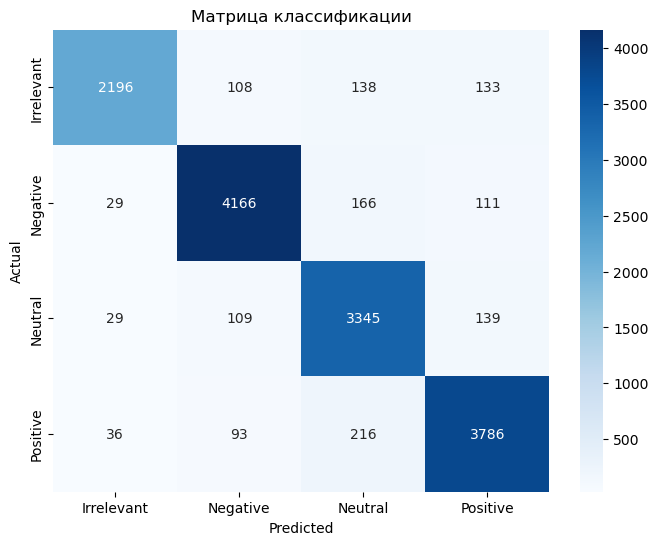

In [18]:
cm = confusion_matrix(y_test, y_pred_test)
labels = [label for label,index in sorted(label_mapping.items(),key=lambda x: x[1])]

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Матрица классификации')
plt.show()

### *Итогом моделирования является модель с отличной точностью, составляющей 91%. В случае необходимости более высоких результатов можно было бы обратиться к модели Опорных векторов, однако ограничения по ресурсам в моём случае сделали слишком проблематичным более детальную настройку данной модели (вследствии чего предпочтение было отдано именно Случайному лесу).*
### *Альтернативным вариантом так же могут стать более сложные ансамблевые модели, однако, как уже было упомянуто выше, значительно возрастает ресурсозатратность*